In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import requests
from IPython.core.display import display, HTML
import re
import dateutil.parser
from datetime import datetime as dt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [2]:
def get_movie_value(soup, field_name):
    obj = soup.find(text=re.compile(field_name))
    if not obj: 
        return None
    # this works for most of the values
    next_element = obj.findNext()
    if next_element:
        return next_element.text 
    else:
        return None

In [3]:
def money_to_int(moneystring):
    try:
        moneystring = moneystring.replace('$', '').replace(',', '')
        return int(moneystring)
    except :
        pass
    
def runtime_to_minutes(runtimestring):
    runtime = runtimestring.split()
    try:
        minutes = int(runtime[0])*60 + int(runtime[2])
        return minutes
    except:
        return None

def to_date(datestring):
    date = dateutil.parser.parse(datestring)
    return date

In [4]:
def movie_info(url):
    response = requests.get(url)
    page = response.text
    soup = BeautifulSoup(page, "lxml")

    title_string = soup.find('title').text
    title_string.split('-')
    title = title_string.split('-')[0].strip()
    
    dtg = soup.find(class_='mojo-performance-summary-table').find_all('span', class_='money')[0].text
    
    runtime = get_movie_value(soup,'Run')
    
    rating = get_movie_value(soup,'MPAA')
    
    release_date = get_movie_value(soup,'Release Date')
    release_date = release_date.split('\n')[0]
    
    distributor = get_movie_value(soup,'Distributor')
    distributor = distributor[:-30]
    
    budget = get_movie_value(soup,'Budget')
    budget = money_to_int(budget)
    
    raw_domestic_total_gross = dtg
    domestic_total_gross = money_to_int(raw_domestic_total_gross)

    raw_runtime = get_movie_value(soup,'Running')
    runtime = runtime_to_minutes(raw_runtime)

    raw_release_date = get_movie_value(soup,'Release Date').split('\n')[0]
    release_date = to_date(raw_release_date)
    
    
    
    genre = get_movie_value(soup,'Genres')
    res = [] 
    for sub in genre: 
        res.append(re.sub('\n', '', sub)) 
    res = ''.join(res)
    res = re.sub(' +', ', ', res)
    
    
    headers = ['Movie_Title','Distributor','Domestic_Total_Gross','Budget',
               'Runtime(mins)', 'Rating', 'Release_Date','Genre']

    movie_data = []
    movie_dict = dict(zip(headers, [title,
                                    distributor,
                                    domestic_total_gross,
                                    budget,
                                    runtime,
                                    rating, 
                                    release_date,
                                    res]))

    movie_data.append(movie_dict)
    return movie_data

In [586]:
def get_urls(years):
    '''Takes a 4 digit year input, or a list of them'''
    url = "https://www.boxofficemojo.com/year/{}/?sort=gross&grossesOption=calendarGrosses"
    dfs = []
    for year in years:
        file_url = url.format(year)
        response = requests.get(file_url)
        page = response.text
        soup = BeautifulSoup(page, "lxml")
        
        k = soup.find_all('a')

        df = pd.DataFrame(np.array(list(k)[26:426]).reshape(-1,2))
        moviepaths = df.loc[:,0]
        #print(pd.DataFrame(moviepaths))
        for item in moviepaths:
            dfs.append(item)
    return dfs

years = ['2019','2018']#,'2017','2016','2015','2014','2013','2012','2011','2010',
         #'2009','2008','2007','2006','2005','2004','2003','2002','2001','2000',]
url_list = get_urls(years)
#url_list

In [588]:
len(url_list)

400

In [55]:
#url1 = "https://www.boxofficemojo.com/year/2019/?sort=gross&grossesOption=calendarGrosses"
#dfs = []
#response = requests.get('https://www.boxofficemojo.com/year/2019/?sort=gross&grossesOption=calendarGrosses')
#page = response.text
#soup = BeautifulSoup(page, "lxml")
#k = soup.find_all('a')






In [56]:
#pd.DataFrame(np.array(list(k)[26:226]).reshape(-1,2))

In [57]:
urls = []
for a_tag in url_list:
    url = a_tag['href']
    if not url.startswith('http'):
        url = "https://www.boxofficemojo.com/"+url
    urls.append(url)
len(urls)

4000

In [8]:
t = movie_info(urls[2])
def getList(dict): 
      
    return [*dict] 
Header = getList(t[0])
#Header

In [58]:
dft = pd.DataFrame(columns=Header)

for i in range(len(urls)):
    try:
        t = movie_info(urls[i])
        dft = dft.append(t, ignore_index=True)
    except:
        pass
    
dft.head()

,Movie_Title,Distributor,Domestic_Total_Gross,Budget,Runtime(mins),Rating,Release_Date,Genre
0,Avengers: Endgame,Walt Disney Studios Motion Pictures,858373000,356000000,181,PG-13,2019-04-26,"Action, Adventure, Drama, Sci-Fi"
1,The Lion King,Walt Disney Studios Motion Pictures,543638043,260000000,118,PG,2019-07-19,"Adventure, Animation, Drama, Family, Musical"
2,Toy Story 4,Walt Disney Studios Motion Pictures,434038008,None,100,G,2019-06-21,"Adventure, Animation, Comedy, Family, Fantasy"
3,Frozen II,Walt Disney Studios Motion Pictures,466518690,None,103,PG,2019-11-22,"Adventure, Animation, Comedy, Family, Fantasy,..."
4,Captain Marvel,Walt Disney Studios Motion Pictures,426829839,None,123,PG-13,2019-03-08,"Action, Adventure, Sci-Fi"


In [59]:
dft.to_pickle('Mv200x20.pkl')

In [60]:
dft

,Movie_Title,Distributor,Domestic_Total_Gross,Budget,Runtime(mins),Rating,Release_Date,Genre
0,Avengers: Endgame,Walt Disney Studios Motion Pictures,858373000,356000000,181,PG-13,2019-04-26,"Action, Adventure, Drama, Sci-Fi"
1,The Lion King,Walt Disney Studios Motion Pictures,543638043,260000000,118,PG,2019-07-19,"Adventure, Animation, Drama, Family, Musical"
2,Toy Story 4,Walt Disney Studios Motion Pictures,434038008,None,100,G,2019-06-21,"Adventure, Animation, Comedy, Family, Fantasy"
3,Frozen II,Walt Disney Studios Motion Pictures,466518690,None,103,PG,2019-11-22,"Adventure, Animation, Comedy, Family, Fantasy,..."
4,Captain Marvel,Walt Disney Studios Motion Pictures,426829839,None,123,PG-13,2019-03-08,"Action, Adventure, Sci-Fi"
...,...,...,...,...,...,...,...,...
2640,What Planet Are You From?,Sony Pictures Releasing,6291602,60000000,105,R,2000-03-03,"Comedy, Sci-Fi"
2641,Croupier,,6201143,None,94,None,2000-04-21,"Crime, Drama"
2642,Double Jeopardy,Paramount Pictures,116741558,70000000,105,R,1999-09-24,"Crime, Drama, Mystery, Thriller"
2643,Africa's Elephant Kingdom,IMAX,13485455,None,None,None,1998-05-01,"Documentary, Short"


In [61]:
dft['strpdate'] = pd.to_datetime(dft.Release_Date, format = "%Y-%M-%D")
dft['year'] = pd.DatetimeIndex(dft['strpdate']).year

In [62]:
dft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2645 entries, 0 to 2644
Data columns (total 10 columns):
Movie_Title             2645 non-null object
Distributor             2645 non-null object
Domestic_Total_Gross    2645 non-null object
Budget                  1952 non-null object
Runtime(mins)           2571 non-null object
Rating                  2516 non-null object
Release_Date            2645 non-null datetime64[ns]
Genre                   2645 non-null object
strpdate                2645 non-null datetime64[ns]
year                    2645 non-null int64
dtypes: datetime64[ns](2), int64(1), object(7)
memory usage: 206.8+ KB


In [63]:
dft.groupby(['year']).Movie_Title.count()

year
1998      6
1999     17
2000    143
2001    145
2002    166
2003    166
2004    146
2005    138
2006     41
2007    117
2008    123
2009    109
2010    149
2011    149
2012    164
2013    120
2014    111
2015     59
2016    135
2017    137
2018    153
2019    151
Name: Movie_Title, dtype: int64

In [27]:
dft['Domestic_Total_Gross'] = dft['Domestic_Total_Gross'].apply(float)
dft['Runtime(mins)'].fillna(value=pd.np.nan, inplace=True)
dft['Runtime(mins)'] = dft['Runtime(mins)'].apply(float)
dft['Budget'].fillna(value=pd.np.nan, inplace=True)
dft['Budget'] = dft['Budget'].apply(float)
dft['CPMin'] = dft['Budget']/dft['Runtime(mins)']
#dft['GvBRatio'] = dft['Domestic_Total_Gross']/dft['Budget']
#dft['Profits'] = dft['Domestic_Total_Gross'] - dft['Budget']

In [34]:
dft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1673 entries, 0 to 1672
Data columns (total 13 columns):
Movie_Title             1673 non-null object
Distributor             1673 non-null object
Domestic_Total_Gross    1673 non-null float64
Budget                  1430 non-null float64
Runtime(mins)           1650 non-null float64
Rating                  1634 non-null object
Release_Date            1673 non-null datetime64[ns]
Genre                   1673 non-null object
strpdate                1673 non-null datetime64[ns]
year                    1673 non-null int64
CPMin                   1412 non-null float64
GvBRatio                1430 non-null float64
Profits                 1430 non-null float64
dtypes: datetime64[ns](2), float64(6), int64(1), object(4)
memory usage: 170.0+ KB


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


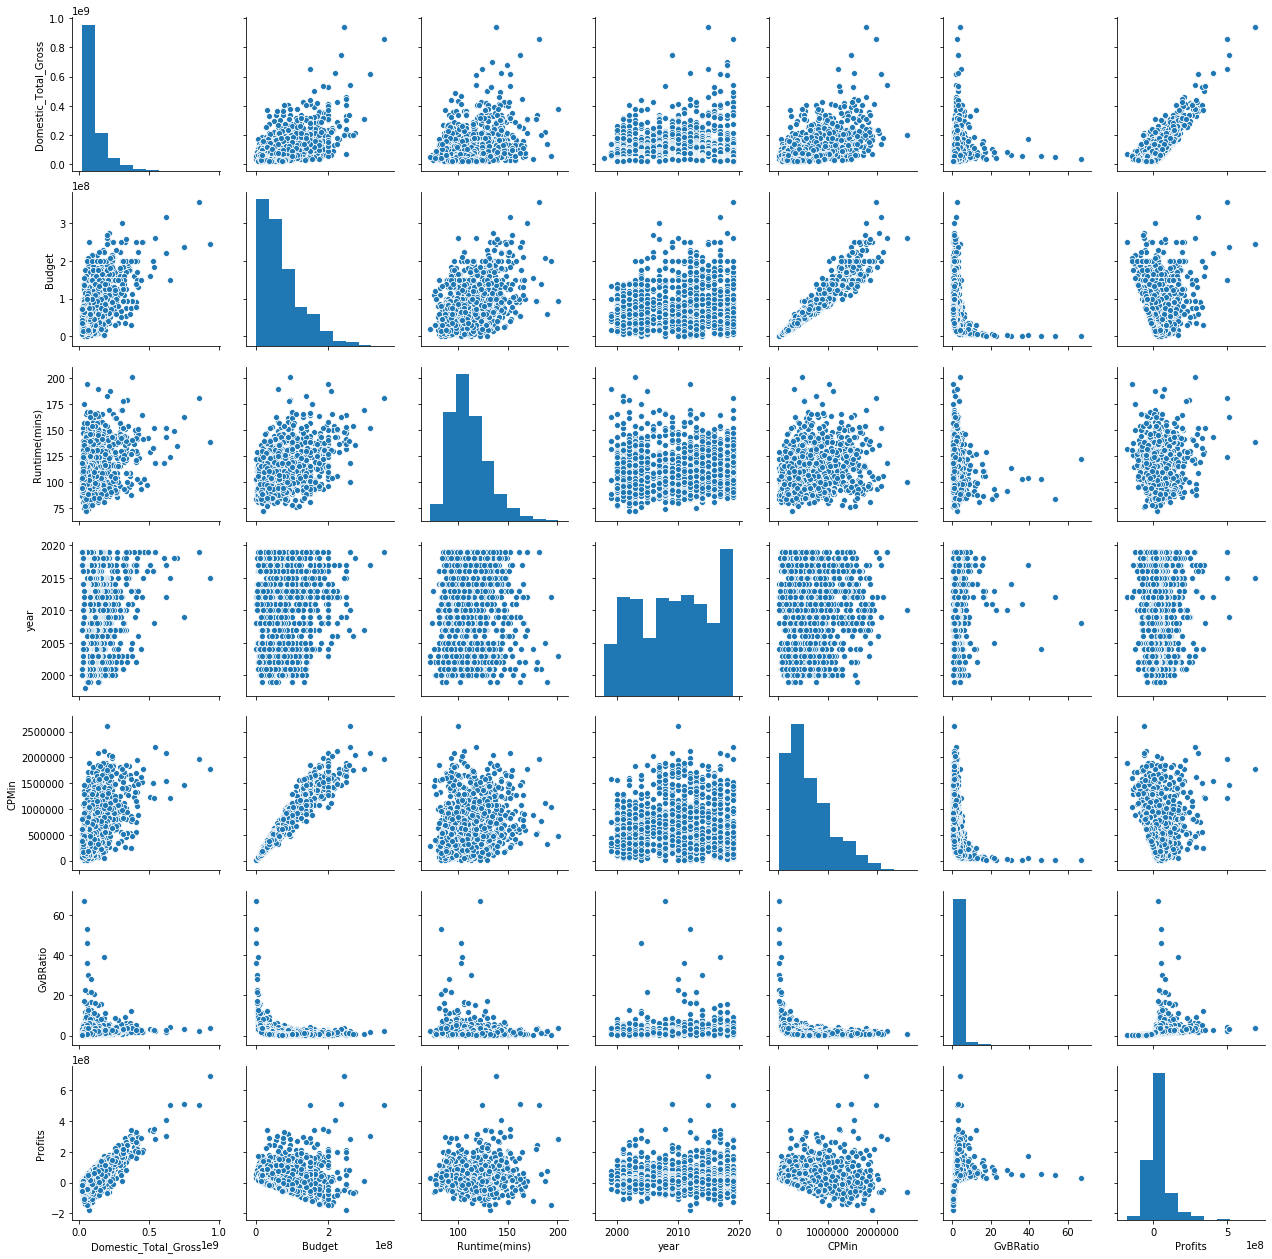

In [29]:
sns.pairplot(dft)

In [40]:
dftN = dft.dropna()

In [46]:
lr = LinearRegression()
lr.fit(dftN[['Budget','Runtime(mins)']],dftN['Domestic_Total_Gross'])
lr.score(dftN[['Budget','Runtime(mins)']],dftN['Domestic_Total_Gross'])

0.3954597024999164

In [47]:
lr.coef_

array([1.00088736e+00, 6.54250285e+05])

In [48]:
lr = LinearRegression()
lr.fit(dftN[['Budget','Runtime(mins)','CPMin','year']],dftN['Domestic_Total_Gross'])
lr.score(dftN[['Budget','Runtime(mins)','CPMin','year']],dftN['Domestic_Total_Gross'])

0.4109018745476661

In [49]:
lr.coef_

array([ 2.23121651e+00, -2.22583398e+05, -1.43543920e+02,  7.29802618e+05])

In [52]:
lr = LinearRegression()
lr.fit(dftN[['Budget','Runtime(mins)','CPMin','year']],dftN['Domestic_Total_Gross'])
lr.score(dftN[['Budget','Runtime(mins)','CPMin','year']],dftN['Domestic_Total_Gross'])

0.4109018745476661

In [53]:
lr.coef_

array([ 2.23121651e+00, -2.22583398e+05, -1.43543920e+02,  7.29802618e+05])

In [318]:
#https://www.the-numbers.com/movie/budgets/all
def get_urls_budget(years):
    '''Takes a 4 digit year input, or a list of them'''
    url = "https://www.the-numbers.com/movie/budgets/all/{}"
    dfs = []
    for year in years:
        file_url = url.format(year)
        response = requests.get(file_url)
        page = response.text
        soup = BeautifulSoup(page, "lxml")
        
        k = soup.find_all('a')

        df = pd.DataFrame(np.array(list(k))[26:426]).reshape(-1,2)
        moviepaths = df.loc[:,0]
        #print(pd.DataFrame(moviepaths))
        for item in moviepaths:
            dfs.append(item)
    return dfs

page = ['001','101','201','301','401']#,'501','601','701','801','901',
         #'1001','1101','1201','1301','1401','1501','1601','1701','1801','1901']
url_budgets = get_urls_budget(page)

ValueError: cannot reshape array of size 307 into shape (2)

In [234]:
qwertyuiop = pd.DataFrame(columns = ['zxcv','asdf'])
qwertyuiop

,zxcv,asdf


In [304]:
    dfs = pd.DataFrame(columns = ['Movie_Title','Budget'])
    url = "https://www.the-numbers.com/movie/budgets/all/001"
    asdf=[]
    Budget = []
    #for year in years:
    #    file_url = url.format(year)
    response = requests.get(url)
    page = response.text
    soup = BeautifulSoup(page, "lxml")
    k = soup.find_all('a')
    df = (pd.DataFrame(np.array(list(k))[71:-62].reshape(-1,2)))
    movie_title = df.loc[:,1]
    j = list(soup.find_all('td'))
    for i in range(len(j)):
        dfs['Movie_Title'].append(str(j[i]))
    budgets2 = pd.DataFrame(np.array(asdf).reshape(-1,6))[3]
    for i in range(len(budgets2)):
        dfs['Budget'].append(budgets2[i][18:-5])
    #dfs['Movie_Title'] = pd.DataFrame(movie_title)
    #dfs['Budget'] = pd.DataFrame(Budget)

TypeError: cannot concatenate object of type '<class 'str'>'; only Series and DataFrame objs are valid

In [ ]:
def get_urls_budget(years):
    dfs = pd.DataFrame(columns = ['Movie_Title','Budget'])
    url = "https://www.the-numbers.com/movie/budgets/all/{}"
    asdf=[]
    Budget = []
    for year in years:
        file_url = url.format(year)
        response = requests.get(file_url)
        page = response.text
        soup = BeautifulSoup(page, "lxml")
        k = soup.find_all('a')
        df = (pd.DataFrame(np.array(list(k))[71:-62].reshape(-1,2)))
        movie_title = df.loc[:,1]
        j = list(soup.find_all('td'))
        for i in range(len(j)):
            dfs['Movie_Title'].append(str(j[i]))
        budgets2 = pd.DataFrame(np.array(asdf).reshape(-1,6))[3]
        for i in range(len(budgets2)):
            dfs['Budget'].append(budgets2[i][18:-5])
    dfs['Movie_Title'] = movie_title
    dfs['Budget'] = Budget
    #return dfs
#page = ['001','101']#,'201','301','401','501','601','701','801','901',
         #'1001','1101','1201','1301','1401','1501','1601','1701','1801','1901']
#url_budgets = get_urls_budget(page)

In [521]:
dfs = pd.DataFrame(columns = ['Movie_Title','Budget'])
url = "https://www.the-numbers.com/movie/budgets/all/001"
asdf=[]
Budget = []
response = requests.get(url)
page = response.text
soup = BeautifulSoup(page, "lxml")
k = soup.find_all('a')
df = (pd.DataFrame(np.array(list(k))[71:-62].reshape(-1,2)))
movie_title = df.loc[:,1]

j = list(soup.find_all('td'))

for i in range(len(j)):
    asdf.append(str(j[i]))
budgets2 = pd.DataFrame(np.array(asdf).reshape(-1,6))[3]

for i in range(len(budgets2)):
    Budget.append(budgets2[i][18:-5])
dfs['Movie_Title'] = movie_title
dfs['Budget'] = Budget

In [522]:
dfs

,Movie_Title,Budget
0,[Avengers: Endgame],"$400,000,000"
1,[Pirates of the Caribbean: On Stranger Tides],"$379,000,000"
2,[Avengers: Age of Ultron],"$365,000,000"
3,[Star Wars Ep. VII: The Force Awakens],"$306,000,000"
4,[Avengers: Infinity War],"$300,000,000"
...,...,...
95,[Rush Hour 3],"$180,000,000"
96,[The Legend of Tarzan],"$180,000,000"
97,[Hugo],"$180,000,000"
98,[Valerian and the City of a Thousand Planets],"$180,000,000"


In [539]:
 def get_urls_budgetL(years):   
    
    dfs = {}
    url = "https://www.the-numbers.com/movie/budgets/all/{}"
    asdf=[]
    Budget = []
    for year in years:
        file_url = url.format(year)
        response = requests.get(file_url)
        page = response.text
        soup = BeautifulSoup(page, "lxml")
        k = soup.find_all('a')
        df = (pd.DataFrame(np.array(list(k))[71:-62].reshape(-1,2)))
        movie_title = df.loc[:,1]
        asdf=[]
        Budget = []
        
        j = list(soup.find_all('td'))
        
        for i in range(len(j)):
            asdf.append(str(j[i]))
        budgets2 = pd.DataFrame(np.array(asdf).reshape(-1,6))[3]
        for i in range(len(budgets2)):
            Budget.append(budgets2[i][18:-5])
        dfs['Movie_Titles{}'.format(year)] = movie_title
        dfs['Budget{}'.format(year)] = Budget
    #dfs['Movie_Title'] = movie_title
    #dfs['Budget'] = Budget
    return dfs
#years = ['001','101','201','301','401']#,'501','601','701','801','901',
         #'1001','1101','1201','1301','1401','1501','1601','1701','1801','1901']
jkl0 = get_urls_budgetL(['001','101','201','301','401'])
#jkl1 = get_urls_budget([])
#jkl2 = get_urls_budget(['501'])
#jkl3 = get_urls_budget(['601','701'])
#jkl4 = get_urls_budget(['801','901'])



In [540]:
 def get_urls_budgetU(years):   
    
    dfs = {}
    url = "https://www.the-numbers.com/movie/budgets/all/{}"
    asdf=[]
    Budget = []
    for year in years:
        file_url = url.format(year)
        response = requests.get(file_url)
        page = response.text
        soup = BeautifulSoup(page, "lxml")
        k = soup.find_all('a')
        df = (pd.DataFrame(np.array(list(k))[71:-63].reshape(-1,2)))
        movie_title = df.loc[:,1]
        asdf=[]
        Budget = []
        
        j = list(soup.find_all('td'))
        
        for i in range(len(j)):
            asdf.append(str(j[i]))
        budgets2 = pd.DataFrame(np.array(asdf).reshape(-1,6))[3]
        for i in range(len(budgets2)):
            Budget.append(budgets2[i][18:-5])
        dfs['Movie_Titles{}'.format(year)] = movie_title
        dfs['Budget{}'.format(year)] = Budget
    #dfs['Movie_Title'] = movie_title
    #dfs['Budget'] = Budget
    return dfs
jkl1 = get_urls_budgetU(['501','601','701','801','901',
                         '1001','1101','1201','1301','1401','1501','1601','1701','1801','1901'])

In [544]:
len(list(jkl1.values())[3])

100

In [528]:
jkl0_1 = list(jkl0.values())[0:11:2]

In [529]:
len(jkl0_1[1])

100

In [398]:
jkl0_Full = jkl0_1[0]
jkl0_Full1 = jkl0_Full.append(jkl0_1[1], ignore_index=True)
jkl0_Full2 = jkl0_Full1.append(jkl0_1[2], ignore_index=True)
jkl0_Full3 = jkl0_Full2.append(jkl0_1[3], ignore_index=True)
jkl0_Full4 = jkl0_Full3.append(jkl0_1[4], ignore_index=True)

In [405]:
jkl0_Full4

0                                [Avengers: Endgame]
1      [Pirates of the Caribbean: On Stranger Tides]
2                          [Avengers: Age of Ultron]
3             [Star Wars Ep. VII: The Force Awakens]
4                           [Avengers: Infinity War]
                           ...                      
495                                [The Devil's Own]
496                           [K-19: The Widowmaker]
497                            [Conan the Barbarian]
498                           [The Three Musketeers]
499                                    [The Promise]
Name: 1, Length: 500, dtype: object

In [417]:
jkl1_1 = list(jkl1.values())[0:31:2]

In [425]:
jkl1_Full = jkl1_1[0]
jkl1_Full1 = jkl1_Full.append(jkl1_1[1], ignore_index=True)
jkl1_Full2 = jkl1_Full1.append(jkl1_1[2], ignore_index=True)
jkl1_Full3 = jkl1_Full2.append(jkl1_1[3], ignore_index=True)
jkl1_Full4 = jkl1_Full3.append(jkl1_1[4], ignore_index=True)
jkl1_Full5 = jkl1_Full4.append(jkl1_1[5], ignore_index=True)
jkl1_Full6 = jkl1_Full5.append(jkl1_1[6], ignore_index=True)
jkl1_Full7 = jkl1_Full6.append(jkl1_1[7], ignore_index=True)
jkl1_Full8 = jkl1_Full7.append(jkl1_1[8], ignore_index=True)
jkl1_Full9 = jkl1_Full8.append(jkl1_1[9], ignore_index=True)
jkl1_Full10 = jkl1_Full9.append(jkl1_1[10], ignore_index=True)
jkl1_Full11 = jkl1_Full10.append(jkl1_1[11], ignore_index=True)
jkl1_Full12 = jkl1_Full11.append(jkl1_1[12], ignore_index=True)
jkl1_Full13 = jkl1_Full12.append(jkl1_1[13], ignore_index=True)
jkl1_Full14 = jkl1_Full13.append(jkl1_1[14], ignore_index=True)

In [426]:
jkl1_Full14

0              [The Nutcracker in 3D]
1                            [Bright]
2                [Sonic The Hedgehog]
3                  [Army of the Dead]
4                           [Twister]
                    ...              
1495              [Little Black Book]
1496         [Assault On Precinct 13]
1497                  [Runner Runner]
1498        [The Replacement Killers]
1499    [Baahubali 2: The Conclusion]
Name: 1, Length: 1500, dtype: object

In [429]:
Names = jkl0_Full4.append(jkl1_Full14, ignore_index=True)

In [516]:
Names
#Names.to_csv('MovieNamesForBudget.csv', index=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


In [584]:
#Names.to_pickle('MovieNamesForBudget.pkl')

RecursionError: maximum recursion depth exceeded while pickling an object

In [545]:
jkl0_budg = list(jkl0.values())[1:11:2]
jkl1_budg = list(jkl1.values())[1:31:2]



In [546]:
type(jkl0_budg[0])

list

In [548]:
len(jkl1_budg[2])#[-101:-1]

100

In [551]:
jkl0_Full_budg = pd.DataFrame(jkl0_budg[0][0:100])
jkl0_Full_budg1 = jkl0_Full_budg.append(jkl0_budg[1][0:100], ignore_index=True)
jkl0_Full_budg2 = jkl0_Full_budg1.append(jkl0_budg[2][0:100], ignore_index=True)
jkl0_Full_budg3 = jkl0_Full_budg2.append(jkl0_budg[3][0:100], ignore_index=True)
jkl0_Full_budg4 = jkl0_Full_budg3.append(jkl0_budg[4][0:100], ignore_index=True)

In [553]:
jkl0_Full_budg4

,0
0,"$400,000,000"
1,"$379,000,000"
2,"$365,000,000"
3,"$306,000,000"
4,"$300,000,000"
...,...
495,"$90,000,000"
496,"$90,000,000"
497,"$90,000,000"
498,"$90,000,000"


In [558]:
jkl1_Full_budg = pd.DataFrame(jkl1_budg[0])
jkl1_Full_budg1 = jkl1_Full_budg.append(jkl1_budg[1], ignore_index=True)
jkl1_Full_budg2 = jkl1_Full_budg1.append(jkl1_budg[2], ignore_index=True)
jkl1_Full_budg3 = jkl1_Full_budg2.append(jkl1_budg[3], ignore_index=True)
jkl1_Full_budg4 = jkl1_Full_budg3.append(jkl1_budg[4], ignore_index=True)
jkl1_Full_budg5 = jkl1_Full_budg4.append(jkl1_budg[5], ignore_index=True)
jkl1_Full_budg6 = jkl1_Full_budg5.append(jkl1_budg[6], ignore_index=True)
jkl1_Full_budg7 = jkl1_Full_budg6.append(jkl1_budg[7], ignore_index=True)
jkl1_Full_budg8 = jkl1_Full_budg7.append(jkl1_budg[8], ignore_index=True)
jkl1_Full_budg9 = jkl1_Full_budg8.append(jkl1_budg[9], ignore_index=True)
jkl1_Full_budg10 = jkl1_Full_budg9.append(jkl1_budg[10], ignore_index=True)
jkl1_Full_budg11 = jkl1_Full_budg10.append(jkl1_budg[11], ignore_index=True)
jkl1_Full_budg12 = jkl1_Full_budg11.append(jkl1_budg[12], ignore_index=True)
jkl1_Full_budg13 = jkl1_Full_budg12.append(jkl1_budg[13], ignore_index=True)
jkl1_Full_budg14 = jkl1_Full_budg13.append(jkl1_budg[14], ignore_index=True)

In [559]:
jkl1_Full_budg14

,0
0,"$90,000,000"
1,"$90,000,000"
2,"$90,000,000"
3,"$90,000,000"
4,"$88,000,000"
...,...
1495,"$30,000,000"
1496,"$30,000,000"
1497,"$30,000,000"
1498,"$30,000,000"


In [560]:
Budgets = jkl0_Full_budg4.append(jkl1_Full_budg14, ignore_index=True)

In [562]:
#Budgets.to_csv('BudgetsForBudget.csv', index=False)

In [570]:
pd.DataFrame(pdNames)

,1
0,[Avengers: Endgame]
1,[Pirates of the Caribbean: On Stranger Tides]
2,[Avengers: Age of Ultron]
3,[Star Wars Ep. VII: The Force Awakens]
4,[Avengers: Infinity War]
...,...
1995,[Little Black Book]
1996,[Assault On Precinct 13]
1997,[Runner Runner]
1998,[The Replacement Killers]


In [567]:
pdNames = pd.DataFrame(Names)

In [565]:
Budgets

,0
0,"$400,000,000"
1,"$379,000,000"
2,"$365,000,000"
3,"$306,000,000"
4,"$300,000,000"
...,...
1995,"$30,000,000"
1996,"$30,000,000"
1997,"$30,000,000"
1998,"$30,000,000"


In [575]:

rfc= pdNames
rfc['Budgets'] = Budgets

In [577]:
rfc.rename(columns = {1:'Movie_Title'}, inplace = True) 

In [578]:
rfc

,Movie_Title,Budgets
0,[Avengers: Endgame],"$400,000,000"
1,[Pirates of the Caribbean: On Stranger Tides],"$379,000,000"
2,[Avengers: Age of Ultron],"$365,000,000"
3,[Star Wars Ep. VII: The Force Awakens],"$306,000,000"
4,[Avengers: Infinity War],"$300,000,000"
...,...,...
1995,[Little Black Book],"$30,000,000"
1996,[Assault On Precinct 13],"$30,000,000"
1997,[Runner Runner],"$30,000,000"
1998,[The Replacement Killers],"$30,000,000"


In [585]:
rfc.to_csv("Budgets.csv",index=False)

In [380]:
x = []
for i in range(len(jkl_1)):
    for j in range(len(jkl_1[i])):
        x.append(jkl_1[i][j])

In [384]:
pd.DataFrame(x)

KeyError: 0

In [383]:
Titles_set1['Titles'].append(x)

TypeError: cannot concatenate object of type '<class 'bs4.element.Tag'>'; only Series and DataFrame objs are valid

In [374]:
Titles_set1

,Titles
0,0 [Avengers: End...
1,0 [Mission: ImpossibleâFallout] 1 ...
2,0 [Beowulf] 1 ...
3,0 [The Perfect Sto...
4,0 [Hercules] 1 [T...


In [296]:
jkl.values()

dict_values([0                               [Avengers: Endgame]
1     [Pirates of the Caribbean: On Stranger Tides]
2                         [Avengers: Age of Ultron]
3            [Star Wars Ep. VII: The Force Awakens]
4                          [Avengers: Infinity War]
                          ...                      
95                                    [Rush Hour 3]
96                           [The Legend of Tarzan]
97                                           [Hugo]
98    [Valerian and the City of a Thousand Planets]
99                              [Jupiter Ascending]
Name: 1, Length: 100, dtype: object, ['$400,000,000', '$379,000,000', '$365,000,000', '$306,000,000', '$300,000,000', '$300,000,000', '$300,000,000', '$300,000,000', '$275,000,000', '$275,000,000', '$263,700,000', '$263,000,000', '$260,000,000', '$260,000,000', '$258,000,000', '$250,000,000', '$250,000,000', '$250,000,000', '$250,000,000', '$250,000,000', '$250,000,000', '$237,000,000', '$232,000,000', '$230,000

In [268]:
dfs = pd.DataFrame(columns = ['Movie_Title','Budget'])
url = "https://www.the-numbers.com/movie/budgets/all/101"
response = requests.get(url)
page = response.text
soup = BeautifulSoup(page, "lxml")
k = soup.find_all('a')
df = (pd.DataFrame(np.array(list(k))[71:-62].reshape(-1,2)))
movie_title = df.loc[:,1]

j = list(soup.find_all('td'))
asdf=[]
for i in range(len(j)):
    asdf.append(str(j[i]))
budgets2 = pd.DataFrame(np.array(asdf).reshape(-1,6))[3]
Budget = []
for i in range(len(budgets2)):
    Budget.append(budgets2[i][18:-5])
dfs['Movie_Title'] = movie_title
dfs['Budget'] = Budget


In [263]:
dfs

,Movie_Title,Budget
0,[Avengers: Endgame],"$400,000,000"
1,[Pirates of the Caribbean: On Stranger Tides],"$379,000,000"
2,[Avengers: Age of Ultron],"$365,000,000"
3,[Star Wars Ep. VII: The Force Awakens],"$306,000,000"
4,[Avengers: Infinity War],"$300,000,000"
...,...,...
95,[Rush Hour 3],"$180,000,000"
96,[The Legend of Tarzan],"$180,000,000"
97,[Hugo],"$180,000,000"
98,[Valerian and the City of a Thousand Planets],"$180,000,000"


In [248]:
url_budgets

,Movie_Title,Budget
0,[Mission: ImpossibleâFallout],"$178,000,000"
1,[X-Men: Apocalypse],"$178,000,000"
2,[The Meg],"$178,000,000"
3,[Edge of Tomorrow],"$178,000,000"
4,[Captain Marvel],"$175,000,000"
...,...,...
95,[The Last Airbender],"$150,000,000"
96,[Bee Movie],"$150,000,000"
97,[G-Force],"$150,000,000"
98,[Bolt],"$150,000,000"


In [226]:
#dfs = []
#url = "https://www.the-numbers.com/movie/budgets/all/001"
#response = requests.get(url)
#page = response.text
#soup = BeautifulSoup(page, "lxml")
#k = soup.find_all('a')
#df = (pd.DataFrame(np.array(list(k))[71:-62].reshape(-1,2)))
#movie_title = df.loc[:,1]

In [228]:
#movie_title

0                               [Avengers: Endgame]
1     [Pirates of the Caribbean: On Stranger Tides]
2                         [Avengers: Age of Ultron]
3            [Star Wars Ep. VII: The Force Awakens]
4                          [Avengers: Infinity War]
                          ...                      
95                                    [Rush Hour 3]
96                           [The Legend of Tarzan]
97                                           [Hugo]
98    [Valerian and the City of a Thousand Planets]
99                              [Jupiter Ascending]
Name: 1, Length: 100, dtype: object

In [210]:
#(pd.DataFrame(np.array(list(k)))[71:-62]).reshape(-1,2)

AttributeError: 'DataFrame' object has no attribute 'reshape'

In [218]:
#list(k)[71:-62]

[<a href="/box-office-chart/daily/2019/04/23">Apr 23, 2019</a>,
 <a href="/movie/Avengers-Endgame-(2019)#tab=summary">Avengers: Endgame</a>,
 <a href="/box-office-chart/daily/2011/05/20">May 20, 2011</a>,
 <a href="/movie/Pirates-of-the-Caribbean-On-Stranger-Tides#tab=summary">Pirates of the Caribbean: On Stranger Tides</a>,
 <a href="/box-office-chart/daily/2015/04/22">Apr 22, 2015</a>,
 <a href="/movie/Avengers-Age-of-Ultron#tab=summary">Avengers: Age of Ultron</a>,
 <a href="/box-office-chart/daily/2015/12/16">Dec 16, 2015</a>,
 <a href="/movie/Star-Wars-Ep-VII-The-Force-Awakens#tab=summary">Star Wars Ep. VII: The Force Awakens</a>,
 <a href="/box-office-chart/daily/2018/04/25">Apr 25, 2018</a>,
 <a href="/movie/Avengers-Infinity-War#tab=summary">Avengers: Infinity War</a>,
 <a href="/box-office-chart/daily/2007/05/24">May 24, 2007</a>,
 <a href="/movie/Pirates-of-the-Caribbean-At-Worlds-End#tab=summary">Pirates of the Caribbean: At Worldâs End</a>,
 <a href="/box-office-chart/dai

In [187]:
#type(str(xcv[1]))

str

In [189]:
#zxcv=[]
#for i in range(len(xcv)):
#    zxcv.append(str(xcv[i]))

In [204]:
#Movies = np.array(zxcv).reshape(-1,2)#[:,1][i][72:-4]

In [206]:
#MoviesCl = []
#for i in range(len(Movies[:,1])):
#    MoviesCl.append(Movies[:,1][i][72:-4])

In [241]:
#MoviesCl

In [130]:
#k = soup.find_all('td')

In [131]:
#j = list(k)


In [132]:
#type(j[1])

bs4.element.Tag

In [135]:
#asdf=[]
#for i in range(len(j)):
#    asdf.append(str(j[i]))

In [170]:
#budgets2 = pd.DataFrame(np.array(asdf).reshape(-1,6))[3]

In [171]:
#len(budgets2)

100

In [166]:
#op = []
#for i in range(len(budgets2)):
#    op.append(budgets2[i][18:-5])

In [168]:
#len(op)

100

In [216]:
#dfs = []
#url = "https://www.the-numbers.com/movie/budgets/all/001"
#response = requests.get(url)
#page = response.text
#soup = BeautifulSoup(page, "lxml")
#k = soup.find_all('a')
#j = list(soup.find_all('td'))
#asdf=[]
#for i in range(len(j)):
#    asdf.append(str(j[i]))
#budgets2 = pd.DataFrame(np.array(asdf).reshape(-1,6))[3]
##budgets3 = []
#budget = []
#for i in range(len(budgets2)):
#    budget.append(budgets2[i][18:-5])

In [217]:
#budget

['$400,000,000',
 '$379,000,000',
 '$365,000,000',
 '$306,000,000',
 '$300,000,000',
 '$300,000,000',
 '$300,000,000',
 '$300,000,000',
 '$275,000,000',
 '$275,000,000',
 '$263,700,000',
 '$263,000,000',
 '$260,000,000',
 '$260,000,000',
 '$258,000,000',
 '$250,000,000',
 '$250,000,000',
 '$250,000,000',
 '$250,000,000',
 '$250,000,000',
 '$250,000,000',
 '$237,000,000',
 '$232,000,000',
 '$230,000,000',
 '$230,000,000',
 '$230,000,000',
 '$225,000,000',
 '$225,000,000',
 '$225,000,000',
 '$225,000,000',
 '$225,000,000',
 '$224,000,000',
 '$220,000,000',
 '$220,000,000',
 '$217,000,000',
 '$215,000,000',
 '$215,000,000',
 '$210,000,000',
 '$210,000,000',
 '$210,000,000',
 '$210,000,000',
 '$207,000,000',
 '$205,000,000',
 '$200,000,000',
 '$200,000,000',
 '$200,000,000',
 '$200,000,000',
 '$200,000,000',
 '$200,000,000',
 '$200,000,000',
 '$200,000,000',
 '$200,000,000',
 '$200,000,000',
 '$200,000,000',
 '$200,000,000',
 '$200,000,000',
 '$200,000,000',
 '$200,000,000',
 '$200,000,000

In [3]:
pd.read_pickle('Full15yr.pkl')

,Movie_Title,Distributor,Domestic_Total_Gross,Budget,Runtime(mins),Rating,Release_Date,Genre
0,Avengers: Endgame,Walt Disney Studios Motion Pictures,858373000,356000000,181,PG-13,2019-04-26,"Action, Adventure, Drama, Sci-Fi"
1,The Lion King,Walt Disney Studios Motion Pictures,543638043,260000000,118,PG,2019-07-19,"Adventure, Animation, Drama, Family, Musical"
2,Toy Story 4,Walt Disney Studios Motion Pictures,434038008,None,100,G,2019-06-21,"Adventure, Animation, Comedy, Family, Fantasy"
3,Frozen II,Walt Disney Studios Motion Pictures,466850574,None,103,PG,2019-11-22,"Adventure, Animation, Comedy, Family, Fantasy,..."
4,Captain Marvel,Walt Disney Studios Motion Pictures,426829839,None,123,PG-13,2019-03-08,"Action, Adventure, Sci-Fi"
...,...,...,...,...,...,...,...,...
11263,The Comedians of Comedy,Vitagraph Films,549,None,103,None,2005-11-11,"Comedy, Documentary"
11264,The Dark Hours,,423,None,80,R,2005-10-13,"Horror, Thriller"
11265,The Brown Bunny,Wellspring Media,366301,None,93,None,2004-08-27,Drama
11266,Yes Nurse! No Nurse! 2004 Re,Regent Releasing,13325,None,100,None,2004-09-03,"Comedy, Musical"
